<a href="https://colab.research.google.com/github/BHSF35/personal-blog/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of Object Category Detection Using Faster RCNN (2017)

*   To use a different image for this demo, update the `image_url` to point to the URL of the desired image.
*   Click `Runtime -> Change runtime type` and select `T4 GPU` to speed up the object detection process.

In [ ]:
# Install necessary libraries (if not already installed)
!pip install -q torch torchvision matplotlib pillow requests
!apt install -y wget > /dev/null

In [ ]:
# --- STEP 1: Download image  ---
# see https://commons.wikimedia.org/wiki/Commons:Picture_of_the_day
import uuid
image_url_list = {
    "bird": "https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Lilac-breasted_roller_%28Coracias_caudatus%29_Kruger.jpg/500px-Lilac-breasted_roller_%28Coracias_caudatus%29_Kruger.jpg",
    "scene": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/A_Koch_woman.jpg/960px-A_Koch_woman.jpg",
    "painting": "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Leitura_by_Jos%C3%A9_Ferraz_de_Almeida_J%C3%BAnior_1892.jpg/1024px-Leitura_by_Jos%C3%A9_Ferraz_de_Almeida_J%C3%BAnior_1892.jpg"
}
selected_object = "scene"  # CHANGE THIS, IF YOU WANT
image_url = image_url_list[selected_object]
filename = f"image_{uuid.uuid4().hex[:8]}.jpg"
!wget -O $filename $image_url

--2025-08-05 17:07:52--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/A_Koch_woman.jpg/960px-A_Koch_woman.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156900 (153K) [image/jpeg]
Saving to: ‘image_0b67d3e0.jpg’

image_0b67d3e0.jpg  100%[===================>] 153.22K  --.-KB/s    in 0.06s   

2025-08-05 17:07:52 (2.52 MB/s) - ‘image_0b67d3e0.jpg’ saved [156900/156900]



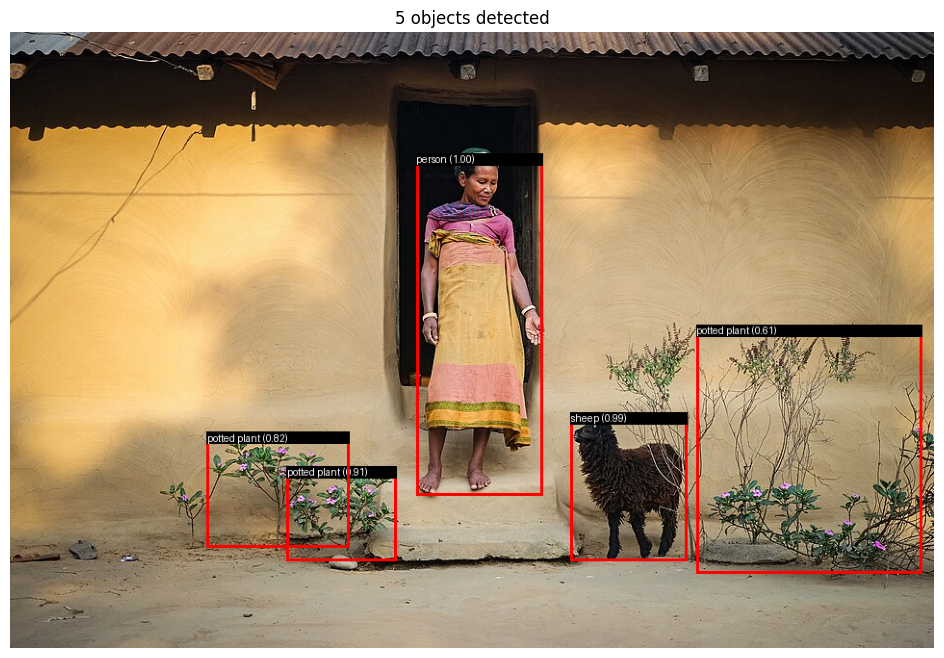

In [ ]:
# Import libraries
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

# Load model with proper weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
model.eval().to(device)

# COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = weights.meta["categories"]

img = Image.open(filename).convert("RGB")

transform = weights.transforms()
img_tensor = transform(img).unsqueeze(0).to(device)

# --- STEP 2: Run inference ---
with torch.no_grad():
    outputs = model(img_tensor)[0]

# --- STEP 3: Draw results ---
draw = ImageDraw.Draw(img)
threshold = 0.6
detected = 0
for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
    if score >= threshold:
        box = box.cpu().numpy()
        label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        draw.rectangle(box, outline='red', width=3)

        # Draw black rectangle behind text
        draw.rectangle( [box[0], box[1], box[0] + (box[2]-box[0]), box[1] + 12], fill='black' )

        # Draw label text in white
        draw.text((box[0], box[1]), f"{label_name} ({score:.2f})", fill='white')
        detected += 1

# === STEP 4: Show detected regions ===
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"{detected} objects detected" if detected else "No objects detected")
plt.show()